In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/clay/userdata/title_generation


In [47]:
import torch
import shutil
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from data_utils import ABCset, MeasureNumberSet, pack_collate, PitchDurSplitSet, FolkRNNSet, MeasureOffsetSet, read_yaml, MeasureEndSet, get_emb_total_size
from emb_trainer import EmbTrainer, EmbTrainerMeasure, EmbTrainerMeasureMRR
from emb_loss import get_batch_contrastive_loss, get_batch_euclidean_loss, clip_crossentropy_loss
from emb_utils import pack_collate_title_sampling_train, pack_collate_title_sampling_valid
from torch.nn import CosineEmbeddingLoss
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

import data_utils
import model_zoo
import emb_model
import emb_data_utils
import vocab_utils

import argparse
import wandb
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = Path('pre_trained/measure_note_xl/')
if path.is_dir():
  yaml_path = list(path.glob('*.yaml'))[0]
  vocab_path = list(path.glob('*vocab.json'))[0]
  checkpoint_list = list(path.glob('*.pt'))
  checkpoint_list.sort(key= lambda x: int(x.stem.split('_')[-2].replace('iter', '')))
  checkpoint_path = checkpoint_list[-1]
  config = data_utils.read_yaml(yaml_path)
  data_param = config.data_params
  model_name = config.nn_params.model_name
  vocab_name = config.nn_params.vocab_name
  net_param = config.nn_params
  vocab = getattr(vocab_utils, vocab_name)(json_path= vocab_path)
  config = data_utils.get_emb_total_size(config, vocab)

In [15]:
score_dir = Path('abc_dataset/folk_rnn_abc_key_cleaned_for_title/')
dataset_name_ttl = "ABCsetTitle_22K"
dataset_abc = getattr(emb_data_utils, dataset_name_ttl)(score_dir, vocab_path, make_vocab=False, key_aug=data_param.key_aug, vocab_name=net_param.vocab_name, tune_length=100)
dataset_abc.vocab = vocab

Error in token measure_offset: <Beam "|">
Error in token measure_offset: <Beam "|">
Error in token measure_offset: <Beam "|">
Error in meas_offset_from_repeat_start: <Beam "|:">
Error in meas_offset_from_repeat_start: <Beam "|:">
Error in meas_offset_from_repeat_start: <Beam "|:">


In [5]:
model_cnn_reducedemb = getattr(emb_model, 'ABC_cnn_emb_Model')(trans_emb=None, vocab_size=vocab.get_size(), net_param=net_param, emb_size=256, hidden_size=128, emb_ratio=1)
model_ttl = getattr(emb_model, 'TTLembModel')(emb_size=256)

# load pretrained model
model_cnn_reducedemb.load_state_dict(torch.load('/home/clay/userdata/title_generation/saved_models/0130_06_transfer_best/measurenote_0.pt')['model'])
model_ttl.load_state_dict(torch.load('/home/clay/userdata/title_generation/saved_models/0130_06_transfer_best/ttlemb_0.pt')['model'])

model_cnn_reducedemb
model_ttl

TTLembModel(
  (layer): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=256, bias=True)
  )
)

In [7]:
torch.manual_seed(42)

trainset, validset = torch.utils.data.random_split(dataset_abc, [int(len(dataset_abc)*0.9), len(dataset_abc) - int(len(dataset_abc)*0.9)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(trainset, batch_size=7000, collate_fn=pack_collate_title_sampling_train, shuffle=True) #collate_fn=pack_collate)
valid_loader = DataLoader(validset, batch_size=7000, collate_fn=pack_collate_title_sampling_valid, shuffle=False) #collate_fn=pack_collate)


In [6]:
valid_loader = DataLoader(dataset_abc, batch_size=7000, collate_fn=pack_collate_title_sampling_valid, shuffle=False) #collate_fn=pack_collate)


In [7]:
dataset_abc.idx2ttl

['The Devil In The Kitchen',
 '10th Bat Crossing Rhine',
 '1st August',
 '2D Or Not 2D',
 'The 30 Year',
 '30th Anniversary',
 '5:30am',
 "The 72nd Highlanders' Farewell To Aberdeen",
 "Tommy Peoples'",
 "79th's Farewell To Gibraltar",
 '93 Not Out',
 'A Barrel Of Knives',
 'A Birthday',
 'The Britches',
 'A Bottle Of Vodka, Twenty Marlboro Reds And £50 Cashback, Please',
 'Love At The Window',
 'Molly On The Shore',
 'A Country Wedding',
 'A Cup Of Tea',
 'Trip To The Quarry',
 'A Day And An Age',
 'A Deanadh Im',
 'A Dram At The Wake',
 'The Fair Wind',
 'A Favourite Duet By Mr Holmes',
 'A Fig For A Kiss',
 'A Fish Out Of Water',
 "A Fisherman's Song For Attracting Seals",
 'A Ghost Of His Former Self',
 'A Glint Of Silver',
 "A Good Night's Sleep",
 'A Great Big Sea Hove In Long Beach',
 'A Highland Quickstep',
 'A Jig For Bernie',
 'A Jig For Christmas',
 'A Jig For Jack',
 'A Jig For Jay',
 'A Jig For Sarah',
 "Jenny Nettle's Fancy",
 "A Maid That's Deep In Love",
 "A Man's A Man

In [11]:
sample = next(iter(valid_loader))
sample[1].shape

torch.Size([4779, 384])

In [20]:
model = SentenceTransformer('all-MiniLM-L6-v2')
sample_emb = model.encode('The Devil In The Kitchen', device='cpu')
sample_emb = torch.tensor(sample_emb)


In [21]:
sample[1][0] == sample_emb
torch.allclose(sample[1][0], sample_emb, atol=1e-4)

True

In [22]:
for batch in valid_loader:
  melody, title, measure_numbers = batch
  valid_abc_emb = model_cnn_reducedemb(melody, measure_numbers)
  valid_ttl_emb = model_ttl(title)

In [23]:
valid_abc_emb = F.normalize(valid_abc_emb, dim=1)
valid_ttl_emb = F.normalize(valid_ttl_emb, dim=1)
valid_cosim = torch.matmul(valid_abc_emb, valid_ttl_emb.T) # 하나의 abc가 다른 모든 ttl들과 가지는 상대적인 거리

In [24]:
len(valid_cosim)

4779

In [25]:
# 1.top K에 해당하는 title들을 출력하고, 실제 title과 비교
# 2.top K의 변화에 따른 acc의 변화
sorted_cosim, sorted_idx = torch.sort(valid_cosim, dim=1, descending=True)

In [42]:
top20K_sorted_idx = sorted_idx[:, :20]
count = 0
for i in range(1000):
  picked_titles = []
  for idx in top20K_sorted_idx[i]:
    picked_titles.append(dataset_abc.idx2ttl[idx.item()])
  with open ('top20K_picked_titles.json', 'a') as f:
    if i in top20K_sorted_idx[i]:
      count += 1
      f.write("*********************Below one got the answer!*********************\n")
    f.write(f"picked_titles : {picked_titles}\n")
    f.write(f"correct_title : {dataset_abc.idx2ttl[i]}\n")
print(count)

39


In [49]:
# drawing top K acc
topK_list = range(1, 1001)
topK_acc_list = []
for topK in topK_list:
  topK_sorted_idx = sorted_idx[:, :topK]
  count = 0
  for i in range(1001):
    if i in topK_sorted_idx[i]:
      count += 1
  topK_acc_list.append(count/1000)


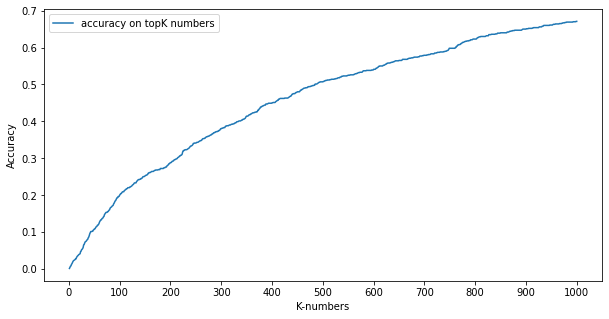

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(topK_list, topK_acc_list, label="accuracy on topK numbers")
plt.xticks(range(0, 1001, 100))
plt.xlabel("K-numbers")
plt.ylabel("Accuracy")
plt.legend()
plt.show()